# BME-230B Spring 2019 HW 2 Question 
James Casaletto, Andrew Davidson, Yuanqing Xue, Jim Zheng

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [GSEAPY: Gene Set Enrichment Analysis in Python. pypi.org](https://pypi.org/project/gseapy/)
    * [GSEAPY: Gene Set Enrichment Analysis in Python gseapy.readthedocs.io](https://gseapy.readthedocs.io/en/latest/introduction.html)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations
    * [Hypergeometric_distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution)
    * [Hypergeometric Tests
for Gene Lists](http://users.unimi.it/marray/2007/material/day4/Lecture7.pdf)

In [1]:
from euclid_knn import KnnG
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

import scipy.special
import scipy.stats as stats

scanpy.__version__:1.4


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot [2 pts: UMAP]. Also report the
modularity of the partition you obtained on the combined dataset [3 pts: Reporting
Modularity].

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")

CPU times: user 4.2 s, sys: 134 ms, total: 4.33 s
Wall time: 1.53 s


In [3]:
# run our implementation of nearest neighboors and update anndata
KnnG(anndata, n_neighbors=12, runPCA=True, nPC=50)

In [4]:
%%time
# running Scanpy's version of Louvian
scanpy.tl.louvain(anndata,
                  flavor='igraph', 
                  directed=False, 
                  use_weights=True)

CPU times: user 7.09 s, sys: 53.6 ms, total: 7.14 s
Wall time: 1.35 s


In [5]:
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

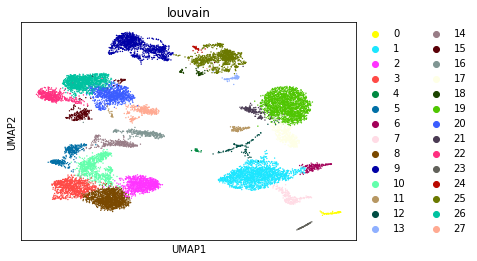

In [6]:
plt.figure(figsize=(10,10))
scanpy.pl.umap(anndata, color=["louvain"])

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [12]:
import hw2q2

In [13]:
cellCountsByClusterId, cellTypesInClusters = hw2q2.createCountsDict(anndata)

In [16]:
annotations = hw2q2.bestAnnotation(anndata, cellTypesInClusters, cellCountsByClusterId)
annotations.sort_values(by=['clusterId'])

,clusterId,Cell type,p-value
0,0,Plasmacytoid dendritic cell,0.000000e+00
1,1,Monocyte_CD14,0.000000e+00
2,2,CD8 T cell,3.223022e-11
3,3,CD4 T cell,0.000000e+00
4,4,Hematopoietic stem cell,0.000000e+00
5,5,CD8 T cell,1.956746e-11
6,6,Monocyte_FCGR3A,0.000000e+00
7,7,Monocyte_CD14,0.000000e+00
8,8,CD4 T cell,7.790102e-12
9,9,B cell,0.000000e+00


## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster

In [18]:
clusterSigs = hw2q2.calculateClusterSignatures(anndata)

In [19]:
%%time
pathways = hw2q2.rankPathWays(anndata, clusterSigs, topN=5)

CPU times: user 2min 46s, sys: 8.38 s, total: 2min 54s
Wall time: 9min 33s


In [20]:
# https://stackoverflow.com/a/35693013/4586180
# display data frame with out index column
from IPython.display import display, HTML
display(HTML(pathways.to_html(index=False)))

Term,nes,cluster id
cellular protein metabolic process (GO:0044267),1.333285,0
Fc-epsilon receptor signaling pathway (GO:0038...,1.323810,0
antigen processing and presentation of exogeno...,1.325697,0
antigen processing and presentation of peptide...,1.352975,0
positive regulation of phosphorylation (GO:004...,1.361454,0
neutrophil degranulation (GO:0043312),2.059123,1
neutrophil activation involved in immune respo...,2.078532,1
neutrophil mediated immunity (GO:0002446),2.107963,1
cellular protein metabolic process (GO:0044267),1.827333,1
granulocyte chemotaxis (GO:0071621),1.694330,1
